In [1]:
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import torch.cuda
import torch.nn as nn
from torch.nn import Linear, ReLU, MSELoss, L1Loss, Sequential, Conv2d, ConvTranspose2d, MaxPool2d, AdaptiveAvgPool2d, Module, BatchNorm2d, Sigmoid, Dropout
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import random_split
from torchvision import datasets, transforms
import os
from PIL import Image

In [4]:
gpu_avail = torch.cuda.is_available()
print(f"Is the GPU available? {gpu_avail}")

Is the GPU available? True


In [5]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [12]:
root_directory = '../DCGAN_instances/celeba_faces1/'
data_dir = root_directory 

transform = transforms.Compose([transforms.Resize(64),
                                transforms.ToTensor()
                               ])
dataset = datasets.ImageFolder(data_dir, transform=transform)
lengths = [int(len(dataset)*0.8), len(dataset)-int(len(dataset)*0.8)]
generator1 = torch.Generator().manual_seed(42)
train_dataset, val_dataset = random_split(dataset, lengths,generator=generator1)
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=2048, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=2048, shuffle=True)

In [5]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

<Axes: >

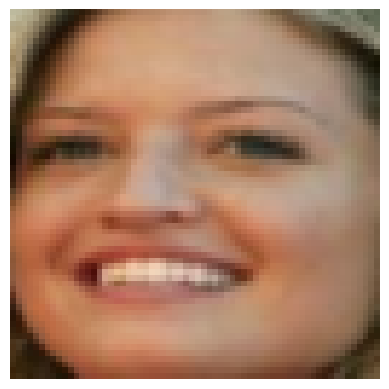

In [6]:
# Visualizing an image from the dataset
images, _ = next(iter(val_dataloader))
imshow(images[1], normalize=False)

In [7]:
def PSNR(input, target):
    EPS = 1e-8
    return -10*torch.log10(torch.mean((input - target) ** 2, dim=[1, 2, 3])+EPS)

In [8]:
def MAE(input, target):
    return torch.mean(abs(input - target), dim=[1, 2, 3])

In [2]:
class autoencoders(nn.Module):
    def __init__(self):
        super(autoencoders, self).__init__()
        self.encoder = Sequential(
            Conv2d(3, 32, kernel_size = (3,3), padding = "same"),
            ReLU(),
            nn.BatchNorm2d(32),
            MaxPool2d((2,2), padding = 0),
            Conv2d(32, 64, kernel_size = (3,3), padding = "same"),
            ReLU(),
            nn.BatchNorm2d(64),
            MaxPool2d((2,2), padding = 0),
            Conv2d(64, 128, kernel_size = (3,3), padding = "same"),
            ReLU(),
            MaxPool2d((2,2), padding = 0)
        )
        self.decoder = Sequential(
            ConvTranspose2d(128, 128, kernel_size = (3,3), stride = 2, padding = 0),
            ReLU(),
            nn.BatchNorm2d(128),
            ConvTranspose2d(128, 64, kernel_size = (3,3), stride = 2, padding = 2),
            ReLU(),
            nn.BatchNorm2d(64),
            ConvTranspose2d(64, 32, kernel_size = (3,3), stride = 1, padding = 0),
            ReLU(),
            ConvTranspose2d(32, 3, kernel_size = (2,2), stride = 2, padding = 1),
            Sigmoid()
        )
        
    def forward(self, images):
        x = self.encoder(images)
        x = self.decoder(x)
        return x

In [7]:
# Function to initialize the model weights
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, nn.Conv2d):
            nn.init.normal_(m.weight.data, 0.0, 0.02)    # mean = 0, variance = 0.02
        if isinstance(m, nn.ConvTranspose2d):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [8]:
model=autoencoders().to(device)
initialize_weights(model)

In [12]:
mae_loss = L1Loss()

In [13]:
def eval_model(model, val_dataloader,epoch):
    model.eval()
    psnr = []
    mae = []
    with torch.no_grad():
        for images, _ in val_dataloader:

            noisy_images = (images + 0.25*torch.normal(0,0.2,images.shape)).clip(0,1)
            images = images.to(device)
            noisy_images = noisy_images.to(device)
            preds = model(noisy_images)
            psnr.extend(PSNR(images.cpu().detach(), preds.cpu().detach()))
            mae.extend(MAE(images.cpu().detach(), preds.cpu().detach()))
            
        print(f"Peak Signal to Noise Ratio:   Mean: {np.array(psnr).mean()} || Std: {np.array(psnr).std()}")
        print(f"Mean absolute Error:   Mean: {np.array(mae).mean()} || Std: {np.array(mae).std()}")
        if epoch%5==0:
            for i in preds:
                img_pred_b=i.detach().cpu().data.numpy().transpose(1, 2, 0)
                img_pred = Image.fromarray((img_pred_b*255).astype(np.uint8))
                plt.imshow(img_pred)
                plt.show()
                break
            for i in images:
                img_orig_b=i.detach().cpu().data.numpy().transpose(1, 2, 0)
                img_orig = Image.fromarray((img_orig_b*255).astype(np.uint8))
                plt.imshow(img_orig)
                plt.show()
                break

            difference_array = np.abs(img_pred_b - img_orig_b)
            
            difference_image = Image.fromarray((difference_array*255).astype(np.uint8))
            plt.imshow(difference_image)
            plt.show()
            
        return np.array(psnr).mean(), np.array(mae).mean()

In [14]:
model_save_dir="DAE_models_2"
os.makedirs(model_save_dir,exist_ok=True)
optimizer = optim.Adam(model.parameters(), lr=3e-3)

  0%|          | 0/80 [00:00<?, ?it/s]

********EPOCH 1:********
Train set:
Peak Signal to Noise Ratio:   Mean: 23.923614501953125 || Std: 1.5064897537231445
Mean absolute Error:   Mean: 0.04774615913629532 || Std: 0.008239205926656723


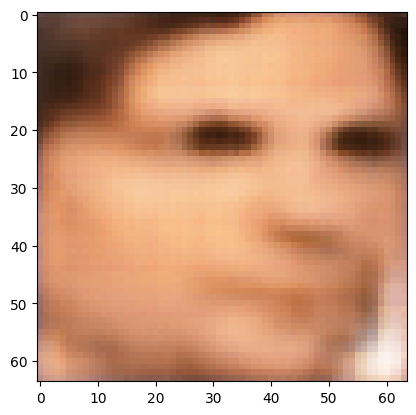

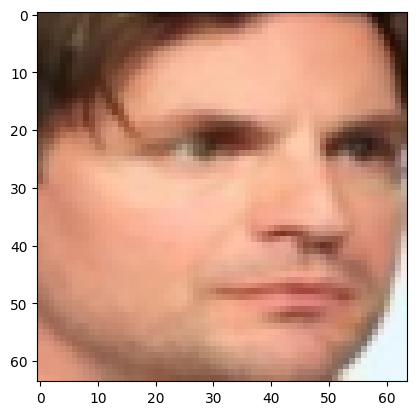

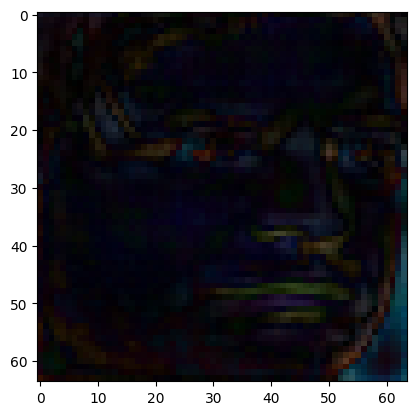

Validation set:
Peak Signal to Noise Ratio:   Mean: 23.939550399780273 || Std: 1.4917715787887573
Mean absolute Error:   Mean: 0.047650646418333054 || Std: 0.008086694404482841


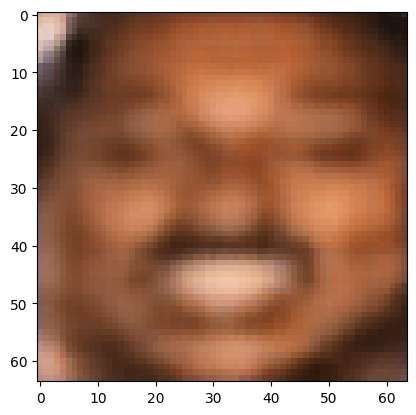

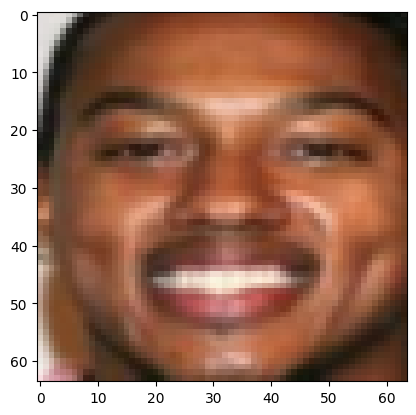

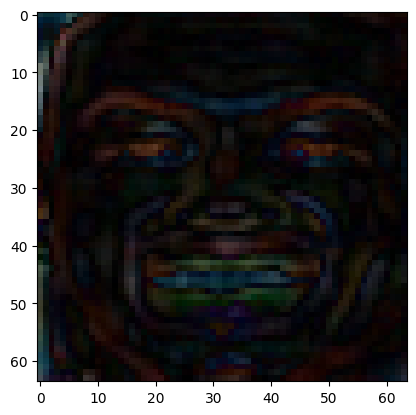

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

********EPOCH 6:********
Train set:
Peak Signal to Noise Ratio:   Mean: 28.28876495361328 || Std: 1.392079472541809
Mean absolute Error:   Mean: 0.028471747413277626 || Std: 0.004410380497574806


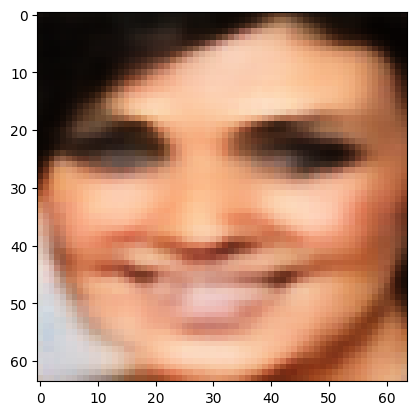

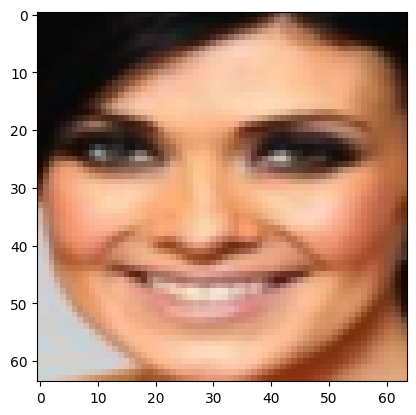

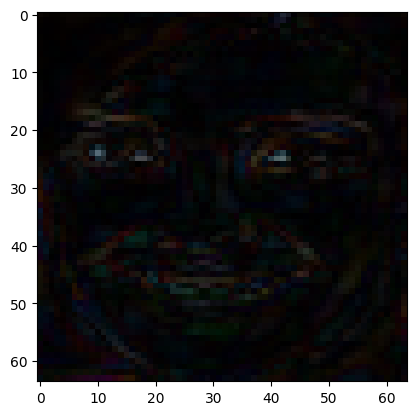

Validation set:
Peak Signal to Noise Ratio:   Mean: 28.30379295349121 || Std: 1.3872392177581787
Mean absolute Error:   Mean: 0.028426742181181908 || Std: 0.004383726976811886


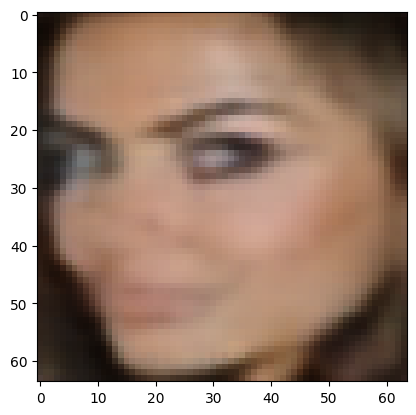

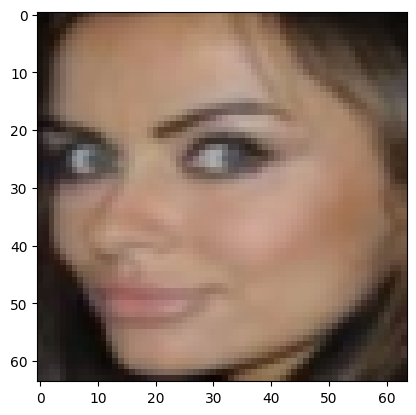

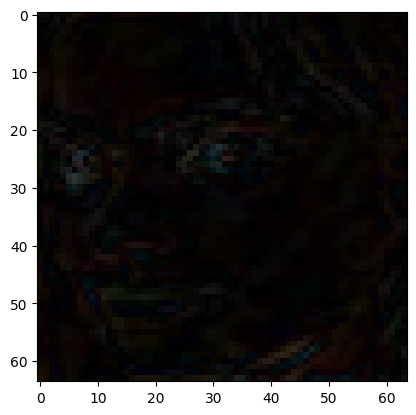

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

********EPOCH 11:********
Train set:
Peak Signal to Noise Ratio:   Mean: 29.695865631103516 || Std: 1.5688756704330444
Mean absolute Error:   Mean: 0.02411024644970894 || Std: 0.004244050942361355


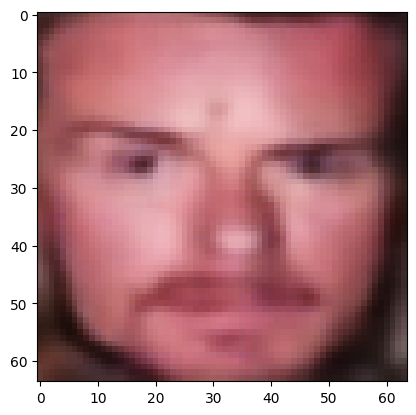

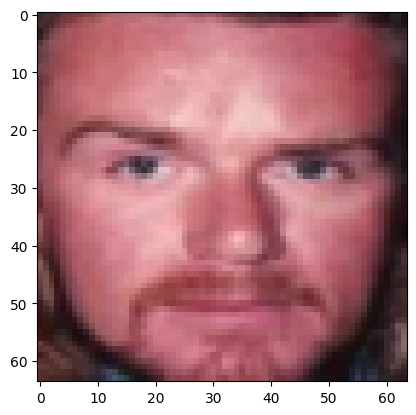

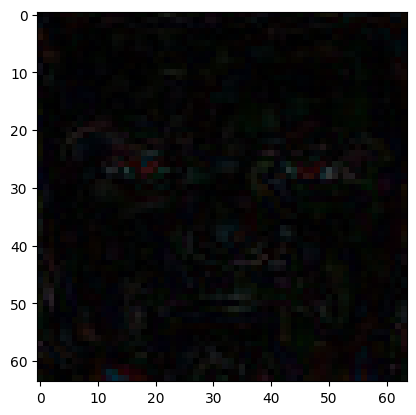

Validation set:
Peak Signal to Noise Ratio:   Mean: 29.71196174621582 || Std: 1.5611215829849243
Mean absolute Error:   Mean: 0.024067247286438942 || Std: 0.004203410819172859


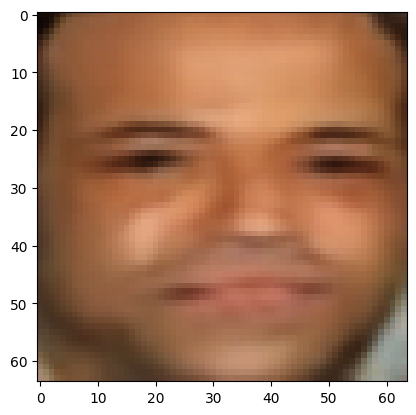

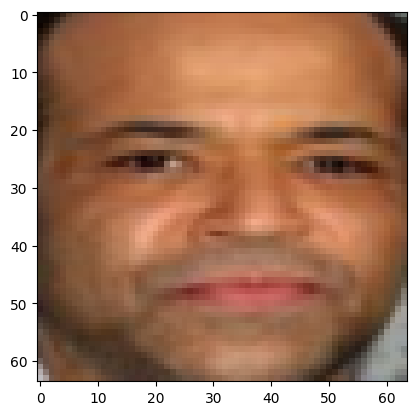

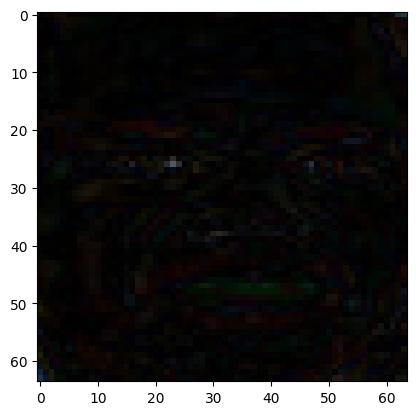

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

********EPOCH 16:********
Train set:
Peak Signal to Noise Ratio:   Mean: 30.355060577392578 || Std: 1.5979198217391968
Mean absolute Error:   Mean: 0.02246978133916855 || Std: 0.003910178784281015


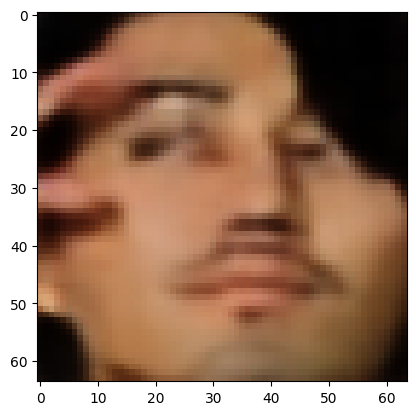

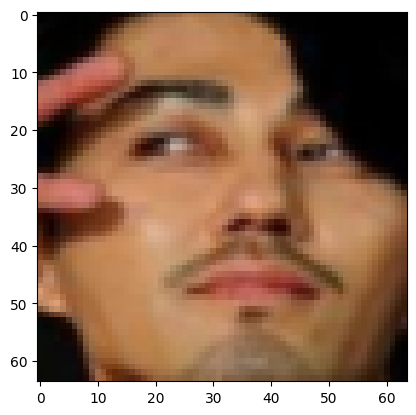

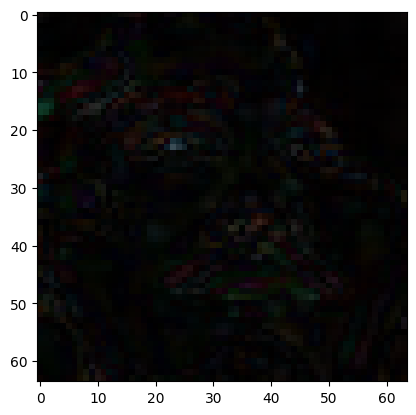

Validation set:
Peak Signal to Noise Ratio:   Mean: 30.370567321777344 || Std: 1.5919182300567627
Mean absolute Error:   Mean: 0.022429635748267174 || Std: 0.003877033246681094


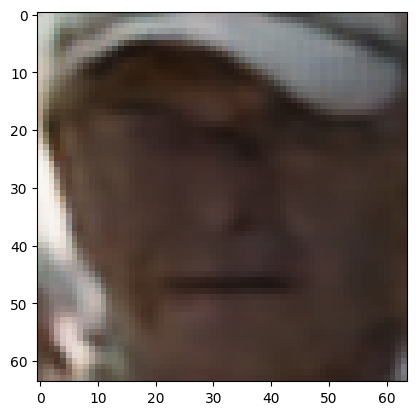

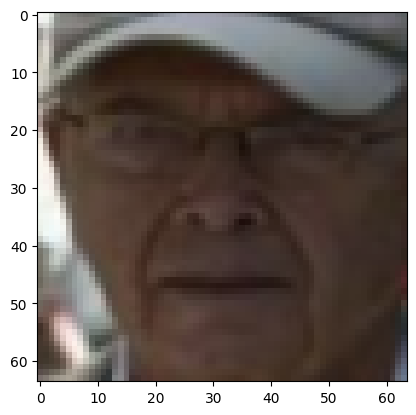

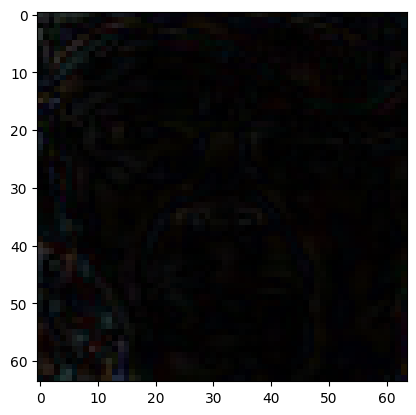

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

********EPOCH 21:********
Train set:
Peak Signal to Noise Ratio:   Mean: 30.38949203491211 || Std: 1.5409646034240723
Mean absolute Error:   Mean: 0.022530807182192802 || Std: 0.003808677429333329


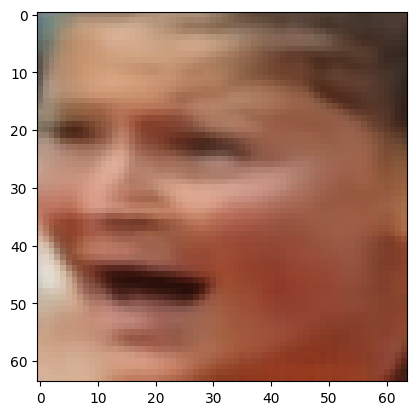

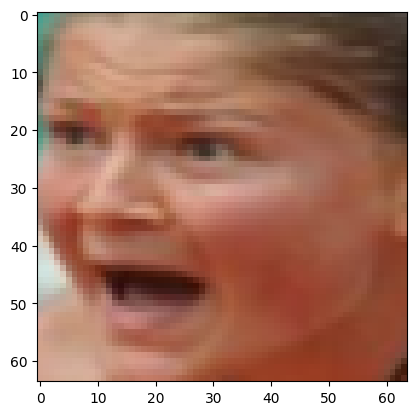

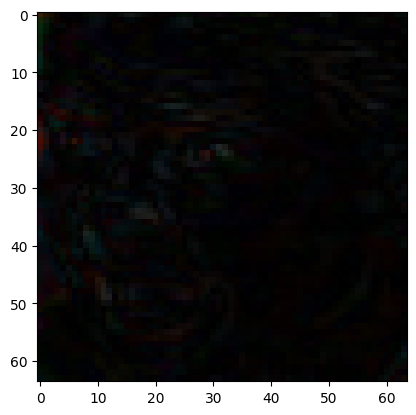

Validation set:
Peak Signal to Noise Ratio:   Mean: 30.401844024658203 || Std: 1.5350556373596191
Mean absolute Error:   Mean: 0.022498853504657745 || Std: 0.00377477309666574


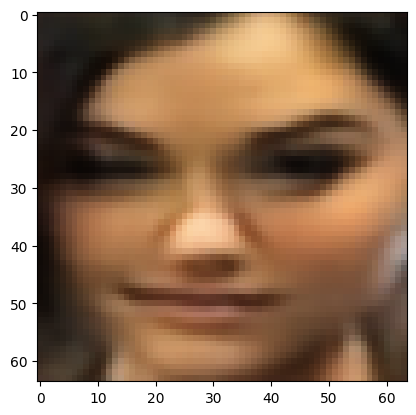

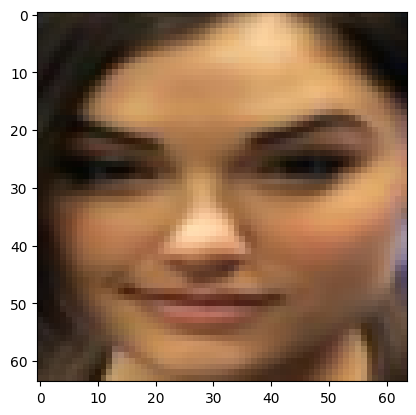

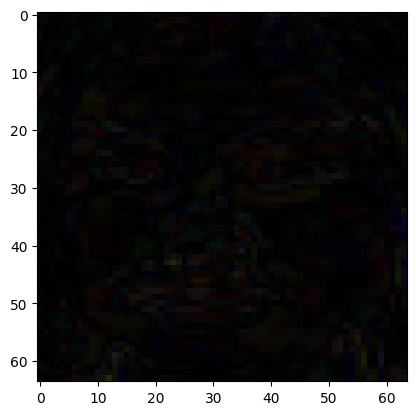

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

********EPOCH 26:********
Train set:
Peak Signal to Noise Ratio:   Mean: 30.814435958862305 || Std: 1.5872814655303955
Mean absolute Error:   Mean: 0.02125982940196991 || Std: 0.0036796373315155506


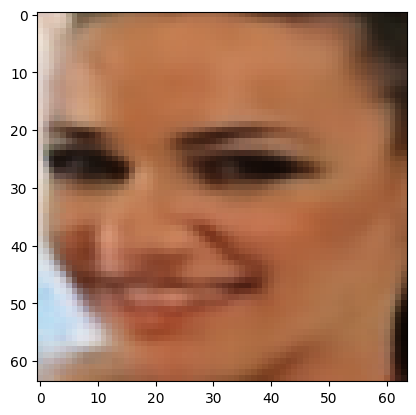

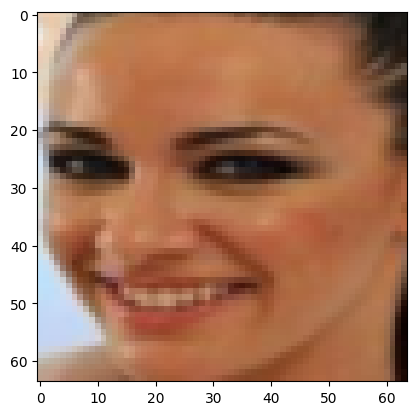

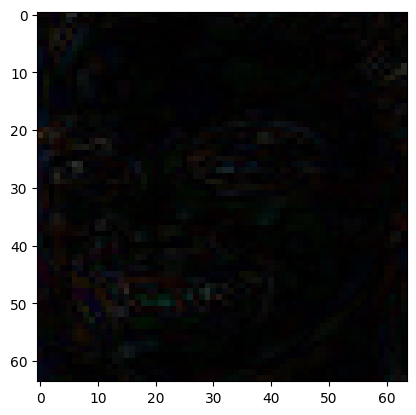

Validation set:
Peak Signal to Noise Ratio:   Mean: 30.829830169677734 || Std: 1.5818228721618652
Mean absolute Error:   Mean: 0.021222436800599098 || Std: 0.0036533987149596214


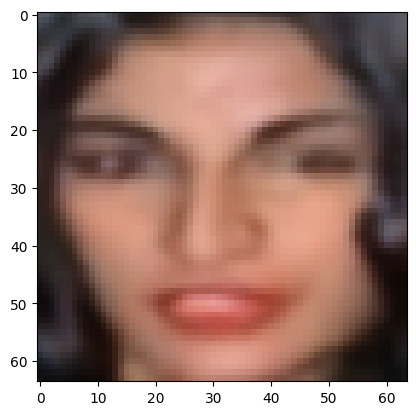

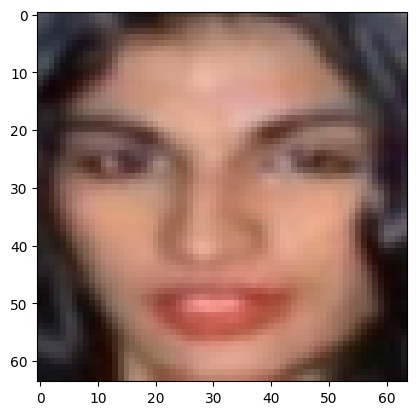

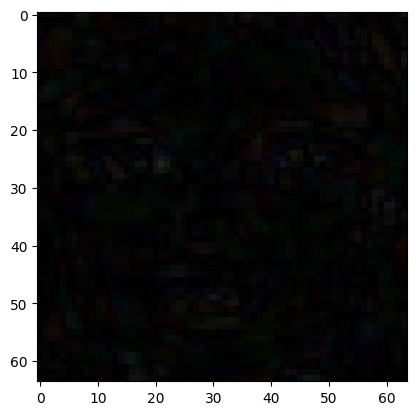

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

********EPOCH 31:********
Train set:
Peak Signal to Noise Ratio:   Mean: 30.904481887817383 || Std: 1.5010913610458374
Mean absolute Error:   Mean: 0.021054305136203766 || Std: 0.003486465662717819


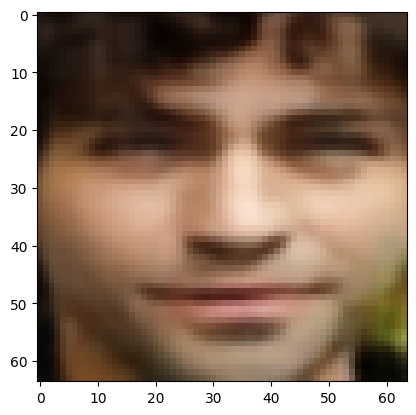

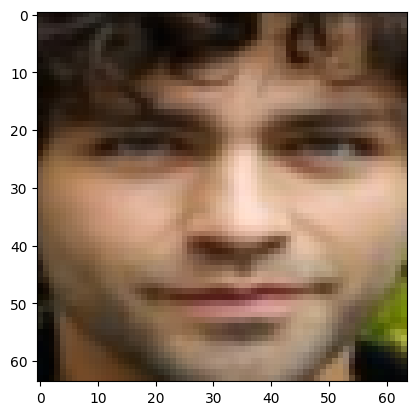

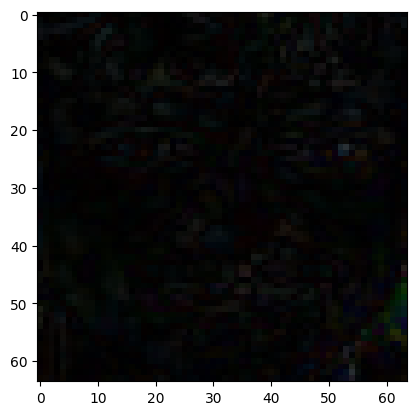

Validation set:
Peak Signal to Noise Ratio:   Mean: 30.91870880126953 || Std: 1.4969027042388916
Mean absolute Error:   Mean: 0.021023694425821304 || Std: 0.0034616836346685886


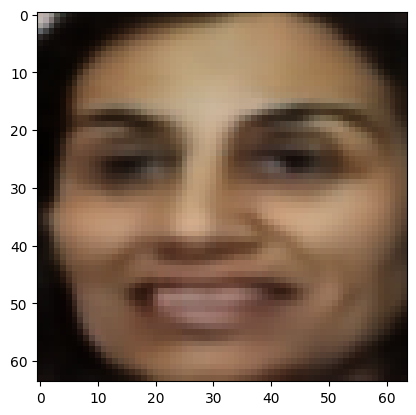

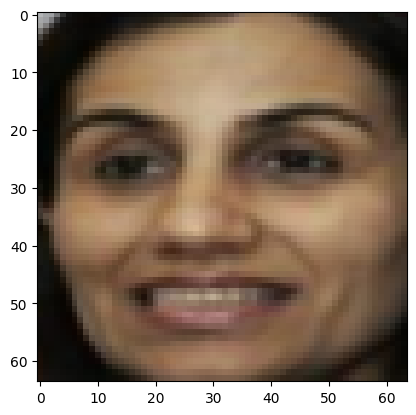

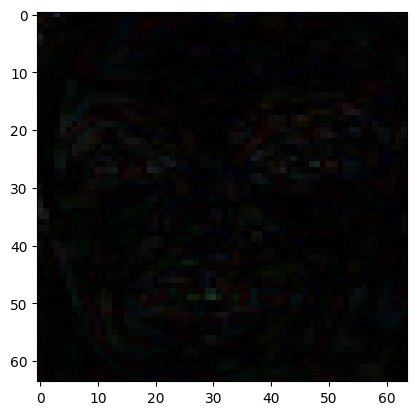

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

********EPOCH 36:********
Train set:
Peak Signal to Noise Ratio:   Mean: 30.651912689208984 || Std: 1.4560315608978271
Mean absolute Error:   Mean: 0.02216183952987194 || Std: 0.0036162484902888536


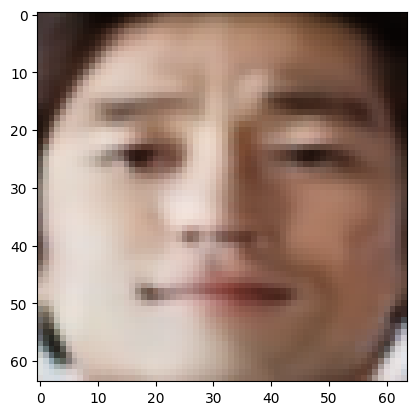

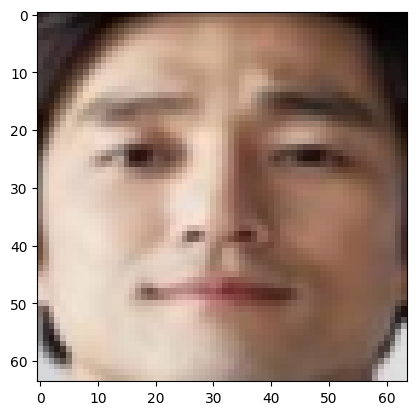

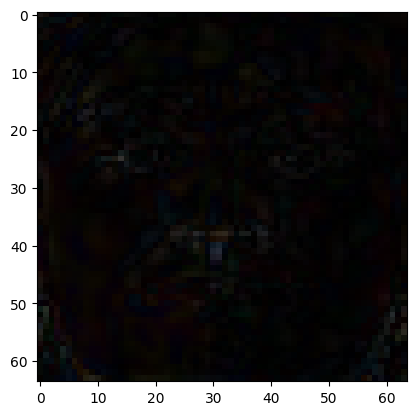

Validation set:
Peak Signal to Noise Ratio:   Mean: 30.66289710998535 || Std: 1.4471700191497803
Mean absolute Error:   Mean: 0.022132962942123413 || Std: 0.003580491291359067


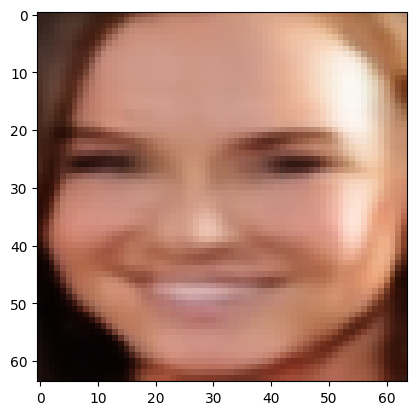

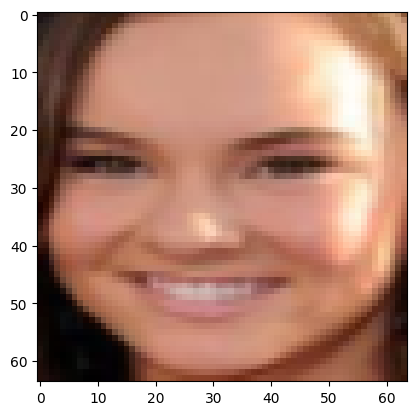

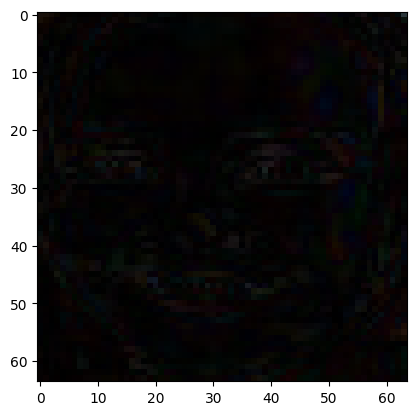

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

********EPOCH 41:********
Train set:
Peak Signal to Noise Ratio:   Mean: 30.34207534790039 || Std: 1.500582218170166
Mean absolute Error:   Mean: 0.022944539785385132 || Std: 0.003737421939149499


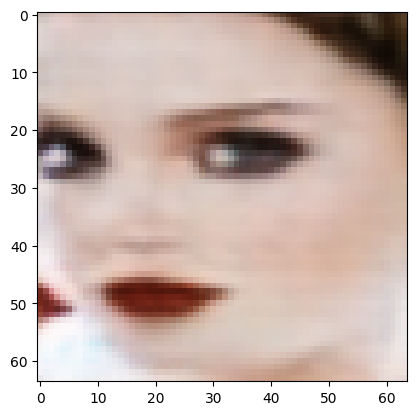

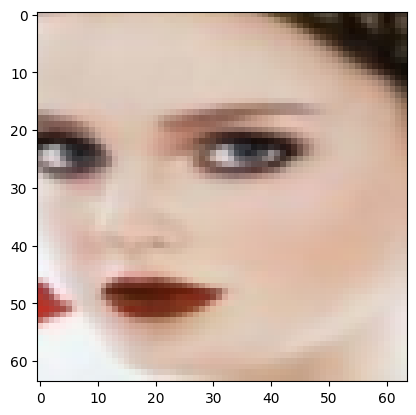

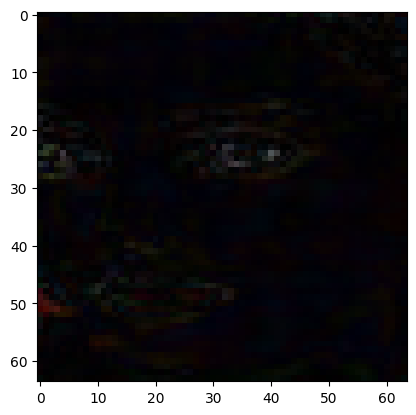

Validation set:
Peak Signal to Noise Ratio:   Mean: 30.355484008789062 || Std: 1.4929229021072388
Mean absolute Error:   Mean: 0.02290886454284191 || Std: 0.003704580245539546


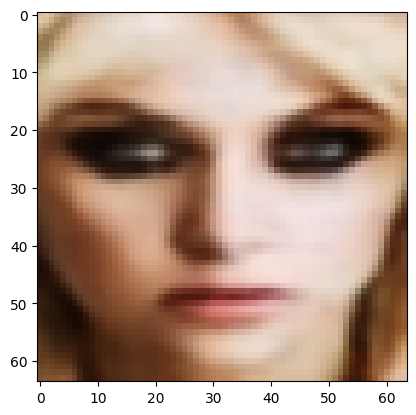

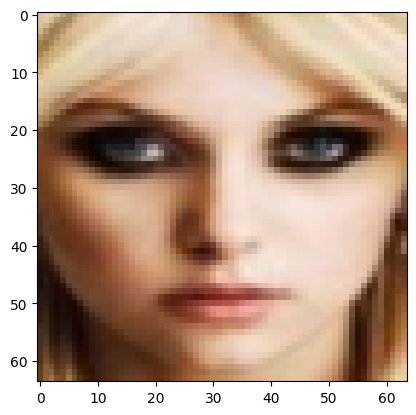

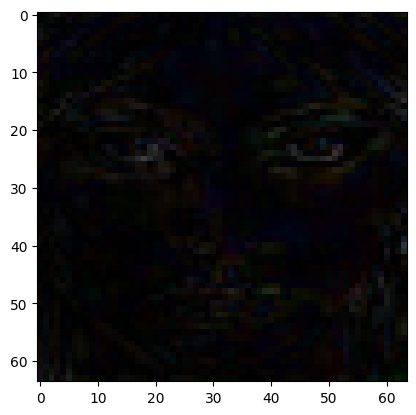

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

********EPOCH 46:********
Train set:
Peak Signal to Noise Ratio:   Mean: 31.1362361907959 || Std: 1.4601460695266724
Mean absolute Error:   Mean: 0.020652752369642258 || Std: 0.00330749386921525


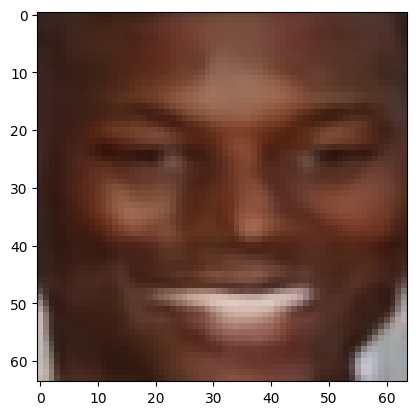

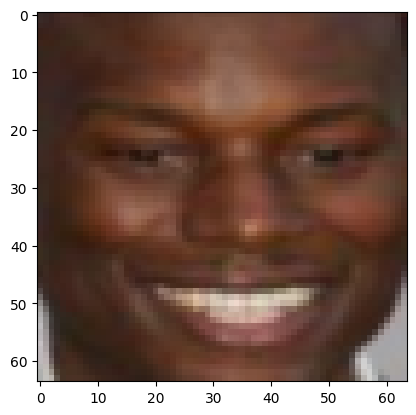

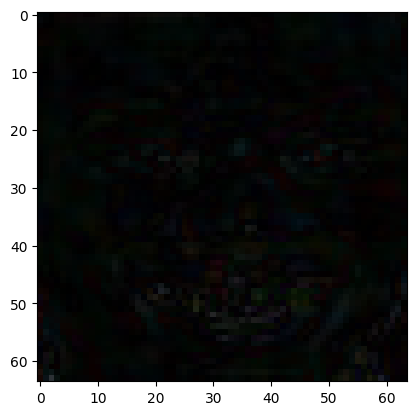

Validation set:
Peak Signal to Noise Ratio:   Mean: 31.148822784423828 || Std: 1.4562560319900513
Mean absolute Error:   Mean: 0.020624307915568352 || Std: 0.0032841512002050877


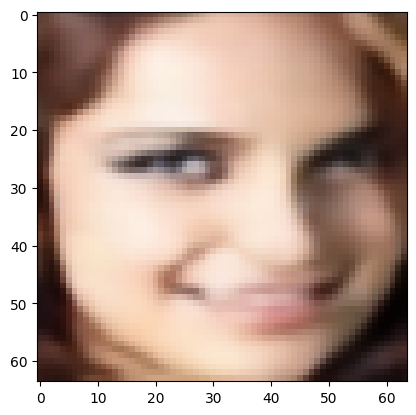

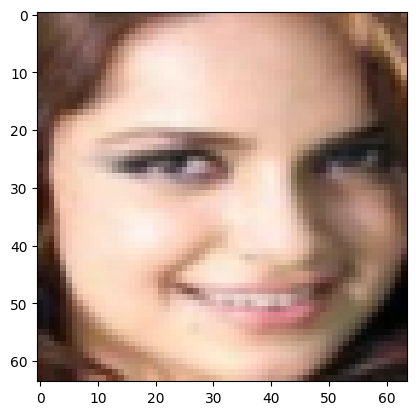

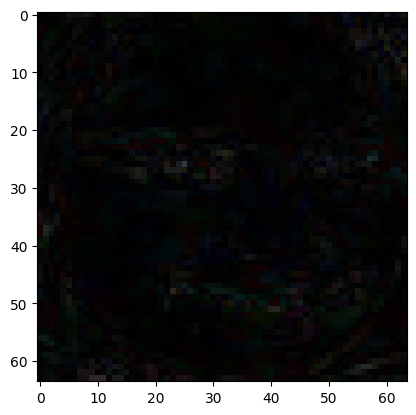

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

In [15]:
num_epochs=50
epoch_num = []
mae_train = []
mae_val = []
psnr_train = []
psnr_val = []
mae = 0.0
psnr = 0.0
model.train()
for epoch in range(num_epochs):
    for images, _ in tqdm(train_dataloader):
        targets = torch.clone(images)

        images = (images + 0.25*torch.normal(0,0.2,images.shape)).clip(0,1)     
        images = images.to(device)
        targets = targets.to(device)
        preds = model(images)
        loss = mae_loss(preds, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    if (epoch%5 == 0):
        print(f"********EPOCH {epoch+1}:********")
        epoch_num.append(epoch+1)
        print("Train set:")
        psnr, mae = eval_model(model, train_dataloader,epoch)
        psnr_train.append(psnr)
        mae_train.append(mae)
        print("Validation set:")
        psnr, mae = eval_model(model, val_dataloader,epoch)
        
        psnr_val.append(psnr)
        mae_val.append(mae)
        state={"DAE_weights":model.state_dict(),"opt":optimizer.state_dict()}
        model_name=os.path.join(model_save_dir,f"DAE_{epoch}.pth")
        torch.save(state,model_name)
        model.train()

In [16]:
state={"DAE_weights":model.state_dict(),"opt":optimizer.state_dict()}
model_name=os.path.join(model_save_dir,f"DAE_{epoch}.pth")
torch.save(state,model_name)

Peak Signal to Noise Ratio:   Mean: 23.785627365112305 || Std: 1.559967041015625
Mean absolute Error:   Mean: 0.05002028867602348 || Std: 0.009039225056767464


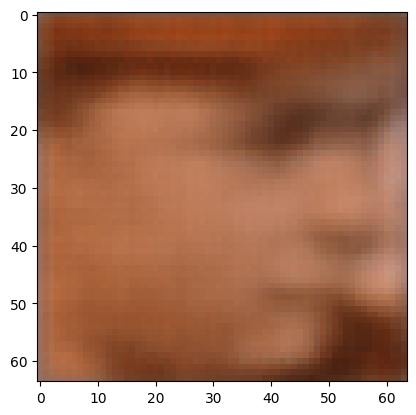

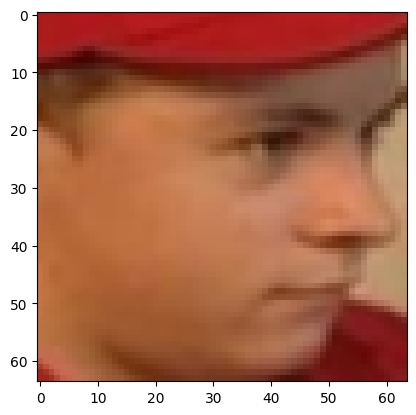

TypeError: unsupported operand type(s) for -: 'Image' and 'Image'

In [21]:
psnr, mse = eval_model(model, val_dataloader,epoch)

Peak Signal to Noise Ratio:   Mean: 31.022533416748047 || Std: 1.4881678819656372
Mean absolute Error:   Mean: 0.020925160497426987 || Std: 0.003364191623404622


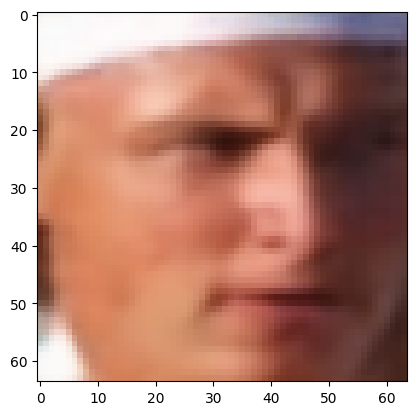

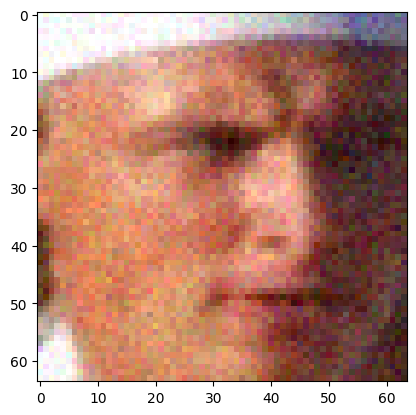

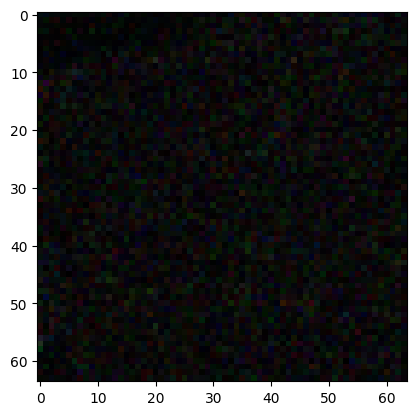

In [19]:
model.eval()
psnr = []
mae = []
epoch=50
with torch.no_grad():
    for images, _ in val_dataloader:

        noisy_images = (images + 0.25*torch.normal(0,0.2,images.shape)).clip(0,1)
        images = images.to(device)
        noisy_images = noisy_images.to(device)
        preds = model(noisy_images)
        psnr.extend(PSNR(images.cpu().detach(), preds.cpu().detach()))
        mae.extend(MAE(images.cpu().detach(), preds.cpu().detach()))
        break
        
    print(f"Peak Signal to Noise Ratio:   Mean: {np.array(psnr).mean()} || Std: {np.array(psnr).std()}")
    print(f"Mean absolute Error:   Mean: {np.array(mae).mean()} || Std: {np.array(mae).std()}")
    if epoch%5==0:
        for i in preds:
            img_pred_b=i.detach().cpu().data.numpy().transpose(1, 2, 0)
            img_pred = Image.fromarray((img_pred_b*255).astype(np.uint8))
            plt.imshow(img_pred)
            plt.show()
            break
        for i in noisy_images:
            img_orig_b=i.detach().cpu().data.numpy().transpose(1, 2, 0)
            img_orig = Image.fromarray((img_orig_b*255).astype(np.uint8))
            plt.imshow(img_orig)
            plt.show()
            break
        # img_pred_array = np.array(img_pred)
        # img_orig_array = np.array(img_orig)
            
            # Now you can perform the subtraction
        difference_array = np.abs(img_pred_b - img_orig_b)
        
        # If you want to visualize the difference, you can convert the resulting array back to an Image
        difference_image = Image.fromarray((difference_array*255).astype(np.uint8))
        plt.imshow(difference_image)
        plt.show()
        
    #return np.array(psnr).mean(), np.array(mae).mean()

In [11]:
model_save_dir="DAE_models_2"
model_name=os.path.join(model_save_dir,f"DAE_{45}.pth")
state = torch.load(model_name)
model.load_state_dict(state['DAE_weights'])
#optimizer.load_state_dict(state['opt'])

<All keys matched successfully>

In [35]:
model.eval()
epoch=50
with torch.no_grad():
    for images, _ in val_dataloader:
        noisy_images = (images + 0.25*torch.normal(0,0.2,images.shape)).clip(0,1)
        images = images.to(device)
        noisy_images = noisy_images.to(device)
        preds = model(noisy_images)
        break

    for i in range(len(preds)):
        os.makedirs(f"DAE_generated_images/generated",exist_ok=True)
        os.makedirs(f"DAE_generated_images/original",exist_ok=True)
        os.makedirs(f"DAE_generated_images/residual",exist_ok=True)
        img_pred_b=preds[i].detach().cpu().data.numpy().transpose(1, 2, 0)
        img_pred = Image.fromarray((img_pred_b*255).astype(np.uint8))
        img_pred.save(f"DAE_generated_images/generated/{i}.png")
        img_orig_b=images[i].detach().cpu().data.numpy().transpose(1, 2, 0)
        img_orig = Image.fromarray((img_orig_b*255).astype(np.uint8))
        img_orig.save(f"DAE_generated_images/original/{i}.png")

        difference_array = np.abs(img_pred_b - img_orig_b)
        
        # If you want to visualize the difference, you can convert the resulting array back to an Image
        difference_image = Image.fromarray(((difference_array*255)*4).astype(np.uint8))
        difference_image.save(f"DAE_generated_images/residual/{i}.png")
        if i==10:
            break
    #return np.array(psnr).mean(), np.array(mae).mean()

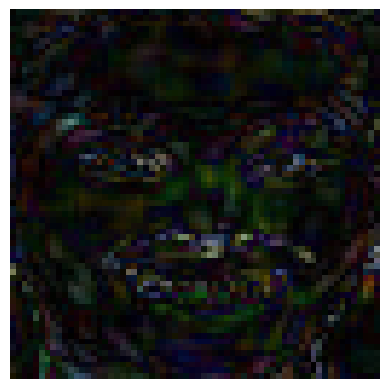

In [39]:
import cv2

img=cv2.imread("DAE_generated_images/residual/9.png")
plt.imshow(img*1)
plt.axis("off")
plt.show()
    

In [23]:
def feval_model(model, val_dataloader,epoch=50):
    model.eval()
    psnr = []
    mae = []
    with torch.no_grad():
        for images, _ in val_dataloader:

            noisy_images = (images + 0.2*torch.normal(0,0.2,images.shape)).clip(0,1)
            images = images.to(device)
            noisy_images = noisy_images.to(device)
            preds = model(noisy_images)
            psnr.extend(PSNR(images.cpu().detach(), preds.cpu().detach()))
            mae.extend(MAE(images.cpu().detach(), preds.cpu().detach()))
        print(f"Peak Signal to Noise Ratio:   Mean: {np.array(psnr).mean()} || Std: {np.array(psnr).std()}")
        print(f"Mean absolute Error:   Mean: {np.array(mae).mean()} || Std: {np.array(mae).std()}")
        if epoch%5==0:
            for i in preds:
                img=i.detach().cpu().data.numpy().transpose(1, 2, 0)
                img = Image.fromarray((img*255).astype(np.uint8))
                plt.imshow(img)
                plt.show()
                break
            for i in images:
                img=i.detach().cpu().data.numpy().transpose(1, 2, 0)
                img = Image.fromarray((img*255).astype(np.uint8))
                plt.imshow(img)
                plt.show()
                break
            
        return np.array(psnr).mean(), np.array(mae).mean()

Peak Signal to Noise Ratio:   Mean: 31.548160552978516 || Std: 1.5806759595870972
Mean absolute Error:   Mean: 0.019516490399837494 || Std: 0.003360860515385866


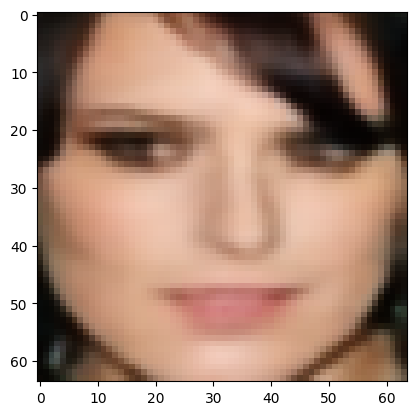

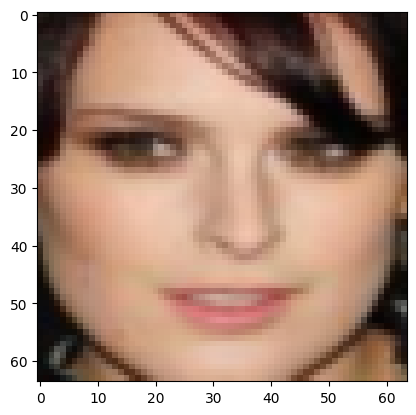

(31.54816, 0.01951649)

In [24]:
feval_model(model, val_dataloader,epoch=50)

Peak Signal to Noise Ratio:   Mean: 30.284677505493164 || Std: 1.594326138496399
Mean absolute Error:   Mean: 0.0 || Std: 0.0037895895075052977


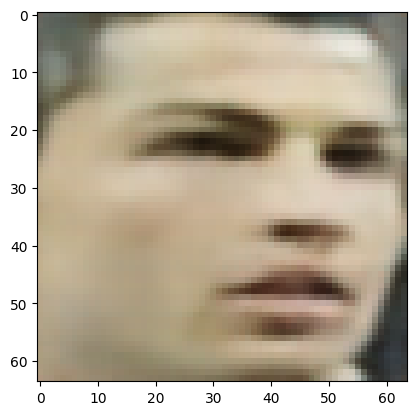

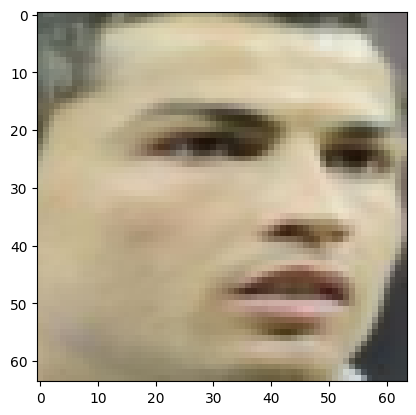

(30.284678, 0.0)

In [21]:
eval_model(model, val_dataloader,epoch)

In [104]:
for images,_ in val_dataloader:
    targets = torch.clone(images)

    images = (images + 0.2*torch.normal(0,0.2,images.shape)).clip(0,1)     
    images = images.to(device)
    targets = targets.to(device)
    preds = model(images)
    break

In [105]:
preds.shape

torch.Size([1024, 3, 64, 64])

(64, 64, 3)
[[[0.559968   0.4954995  0.33789268]
  [0.65158784 0.53308475 0.34722838]
  [0.51004016 0.46318123 0.35582504]
  ...
  [0.57661813 0.6276449  0.5244517 ]
  [0.61737984 0.73944557 0.5686505 ]
  [0.6535938  0.7100582  0.62752783]]

 [[0.6130055  0.5950755  0.40231743]
  [0.5330013  0.5508539  0.4211395 ]
  [0.5542122  0.55132246 0.40863627]
  ...
  [0.68647504 0.7361698  0.6299557 ]
  [0.7623416  0.73338157 0.71451056]
  [0.7736607  0.7151864  0.7257085 ]]

 [[0.52777845 0.53618354 0.3457115 ]
  [0.5855282  0.5727195  0.38791984]
  [0.626293   0.51380545 0.45466998]
  ...
  [0.77058816 0.85740745 0.6362674 ]
  [0.8544415  0.8291397  0.8501926 ]
  [0.86895996 0.93725806 0.8119266 ]]

 ...

 [[0.63943064 0.49230063 0.39517733]
  [0.6160898  0.5073533  0.36800295]
  [0.61184514 0.4172925  0.3393824 ]
  ...
  [0.61902064 0.50536036 0.4126498 ]
  [0.5525632  0.43649876 0.34593195]
  [0.4353118  0.3535603  0.20893049]]

 [[0.5192218  0.5193181  0.37266383]
  [0.56956536 0.4839597  

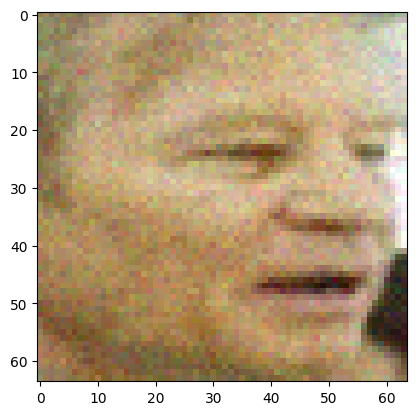

In [106]:
for i in images:
    img=i.detach().cpu().data.numpy().transpose(1, 2, 0)
    print(img.shape)
    print(img)
    #img = Image.fromarray((img*255).astype(np.uint8))
    plt.imshow(img)
    plt.show()
    break

(64, 64, 3)
[[[0.55079937 0.4963916  0.3798099 ]
  [0.5739031  0.5272392  0.3961231 ]
  [0.59326917 0.5419843  0.41025263]
  ...
  [0.6188794  0.6208699  0.58014214]
  [0.67536074 0.6684128  0.6311656 ]
  [0.7360813  0.6908785  0.6542612 ]]

 [[0.5483032  0.5203038  0.37318745]
  [0.55598766 0.5317138  0.39055008]
  [0.57188606 0.53911066 0.3939951 ]
  ...
  [0.70438236 0.7199915  0.65893805]
  [0.7481489  0.75927496 0.7070026 ]
  [0.7926306  0.7867887  0.74895966]]

 [[0.56127477 0.52986246 0.38058588]
  [0.5593977  0.5387651  0.40021777]
  [0.5688626  0.53939617 0.39779836]
  ...
  [0.7934616  0.7985093  0.7492863 ]
  [0.82730573 0.8271502  0.785472  ]
  [0.8552612  0.8422016  0.8153475 ]]

 ...

 [[0.64577    0.51006633 0.3539089 ]
  [0.63568074 0.5033163  0.3432499 ]
  [0.62975675 0.49182624 0.33166447]
  ...
  [0.6712141  0.5417375  0.41395056]
  [0.56078726 0.44436482 0.32361794]
  [0.4634114  0.32391253 0.226965  ]]

 [[0.64463145 0.5131797  0.35812548]
  [0.6322999  0.50312394 

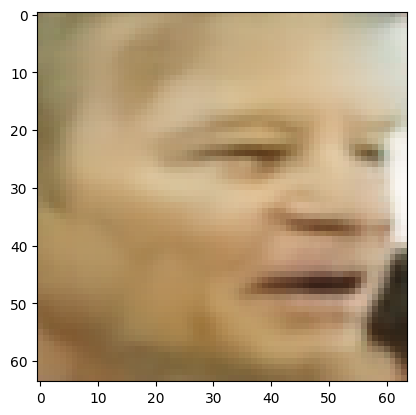

In [107]:
for i in preds:
    img=i.detach().cpu().data.numpy().transpose(1, 2, 0)
    print(img.shape)
    print(img)
    #img = Image.fromarray((img*255).astype(np.uint8))
    plt.imshow(img)
    plt.show()
    break

Peak Signal to Noise Ratio:   Mean: 24.385982513427734 || Std: 1.407334566116333
Mean Squared Error:   Mean: 0.003830953733995557 || Std: 0.0012246647384017706


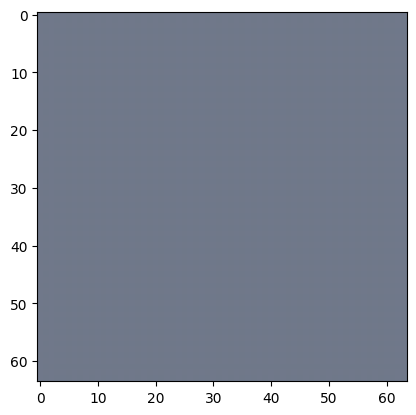

(24.385983, 0.0038309537)

In [59]:
eval_model(model, val_dataloader,epoch=10)

In [17]:
##validation

In [19]:
import cv2
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.keras.layers import *
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-01-30 11:57:03.777105: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-30 11:57:03.810694: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-30 11:57:03.810723: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-30 11:57:03.810750: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-30 11:57:03.820690: I tensorflow/core/platform/cpu_feature_g

In [28]:
root_directory = '../DCGAN_instances/celeba_faces1/celeba_faces'
x_train_noisy=[]
x_train=[]
j=0
for i in os.listdir(root_directory):
    img=cv2.imread(os.path.join(root_directory,i))
    img = cv2.resize(img,(64, 64))
    img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img=img/255.0
    x_train.append(img)
    img=(torch.tensor(img)+torch.normal(0,0.2,img.shape)).clip(0,1)
    
    #img=tf.clip_by_value(img, clip_value_min=0., clip_value_max=1.)
    x_train_noisy.append(img.permute(2,0,1))
    j+=1
    if j==3:
        break
pred=model(torch.stack(x_train_noisy).to(device).to (torch.float32))

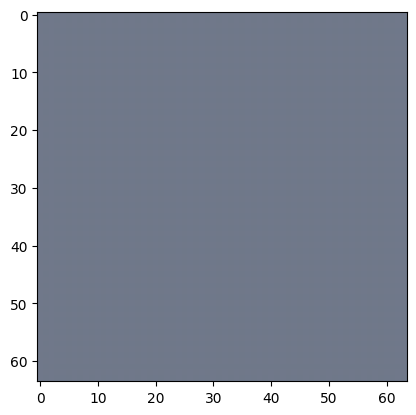

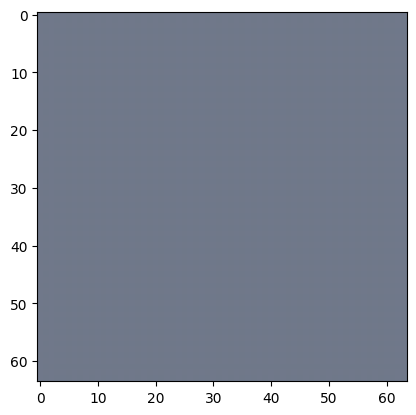

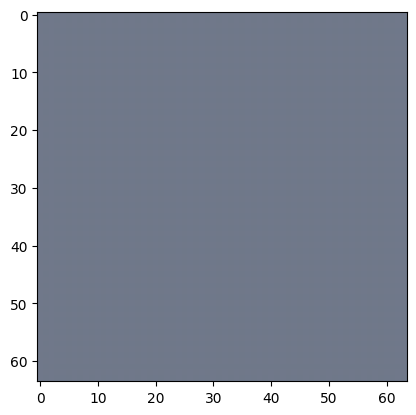

In [31]:
from PIL import Image
for i in pred:
    img=i.detach().cpu().data.numpy().transpose(1, 2, 0)
    img = Image.fromarray((img*255).astype(np.uint8))
    plt.imshow(img)
    plt.show()

In [ ]:
ae = autoencoders()
ae = ae.to(device)

In [ ]:
normal_ae.eval()

In [ ]:
images, _ = next(iter(train_dataloader))
images = images.float().to(device)
output = normal_ae(images)

In [ ]:
imshow(images[1].cpu().detach(), normalize=False)

In [ ]:
images = (images + torch.normal(0,0.2,images.shape)).clip(0,1)

In [ ]:
imshow(images[1], normalize=False)

In [ ]:
output = normal_ae_mse(images.to(device))

In [ ]:
imshow(output[1].cpu().detach(), normalize=False)

In [ ]:
images, _ = next(iter(val_dataloader))
images = images.float().to(device)
output = normal_ae_mse(images)

In [ ]:
imshow(images[1].cpu().detach(), normalize = False)

In [ ]:
noisy_images = (images + torch.normal(0,0.2,images.shape).to(device)).clip(0,1)

In [ ]:
imshow(noisy_images[1].cpu().detach(), normalize = False)

In [ ]:
output = normal_ae_mse(images)

In [ ]:
imshow(output[1].cpu().detach(), normalize=False)

In [ ]:
MSE(images, output)

In [ ]:
PSNR(images, output)

In [ ]:
a = 5*torch.ones(images.shape)
p = torch.poisson(a)
p_norm = p/p.max()
images = (images + p_norm.to(device)).clip(0,1)

In [ ]:
imshow(images[1].cpu().detach(), normalize=False)

In [ ]:
output = normal_ae_mse(images)

In [ ]:
imshow(output[1].cpu().detach(), normalize=False)

<span style="font-size:18px;">The model actually gave a good, but quite oversmoothed, result on a Poisson-Noisy image even though it wasn't trained on it.

In [ ]:
normal_noisy_ae = autoencoders()
normal_noisy_optimizer = optim.Adam(normal_noisy_ae.parameters(), lr=1e-2)
normal_noisy_ae = normal_noisy_ae.to(device)

In [ ]:
%%time
train_model(normal_noisy_ae, "noisy", 0.2, normal_noisy_optimizer, train_dataloader, loss_module)

<span style="font-size:18px;">Here I actually wanted to try an idea presented by J.Lehtinen et al. in the paper "Noise2Noise: Learning Image Restoration without Clean Data" ; basically providing noisy target and the optimization problem would lead the model to find the clean representation based on the hypothesis that the noise is centered.

In [ ]:
images = images.float().to(device)
output = normal_noisy_ae(images)

In [ ]:
imshow(images[1].cpu().detach(), normalize=False)

In [ ]:
imshow(output[1].cpu().detach(), normalize=False)

In [ ]:
images = (images + torch.normal(0,0.2,images.shape).to(device)).clip(0,1)

In [ ]:
imshow(images[1].cpu().detach(), normalize=False)

In [ ]:
output = normal_noisy_ae(images)

In [ ]:
imshow(output[1].cpu().detach(), normalize=False)

<span style="font-size:18px;">Unfortunately, after training for a long time (around 6 hours), the model wasn't able to provide the desired result. This can be due to the limited size of the model or the number of the training epochs.

In [ ]:
normal_noisy_optimizer = optim.Adam(normal_noisy_ae.parameters(), lr=0.005)

In [ ]:
%%time
train_model(normal_noisy_ae, "clean", 0.2, normal_noisy_optimizer, train_dataloader, loss_module, num_epochs = 50)

In [ ]:
imshow(images[1].cpu().detach(), normalize=False)

In [ ]:
noisy_images = (images + torch.normal(0,0.2,images.shape)).clip(0,1).to(device)

In [ ]:
imshow(noisy_images[1].cpu().detach(), normalize=False)

In [ ]:
output = normal_noisy_ae(noisy_images)

In [ ]:
imshow(output[1].cpu().detach(), normalize=False)

<span style="font-size:18px;">I trained the model this time on clean target (keeping the same model that was trained on noisy data), but it seems like there is no hope with it so we decided to move on from the idea.

In [ ]:
# Saving the weights of the first model
state_dict = normal_ae_mse.state_dict()
print(state_dict)

In [ ]:
loss_module = L1Loss()

In [ ]:
normal_ae_mae = autoencoders()
normal_optimizer_mae = optim.Adam(normal_ae_mae.parameters(), lr=1e-3)
normal_ae_mae = normal_ae_mae.to(device)

In [ ]:
%%time
train_model(normal_ae_mae, "normal", 0.2, normal_optimizer_mae, train_dataloader, val_dataloader, loss_module)

<span style="font-size:18px;">We trained the second model (same architecture but different loss function).

In [ ]:
images = images.float().to(device)

In [ ]:
imshow(images[1].cpu().detach(), normalize = False)

In [ ]:
output = normal_ae_mae(images)

In [ ]:
imshow(output[1].cpu().detach(), normalize = False)

In [ ]:
noisy_images = (images.cpu().detach() + torch.normal(0,0.2,images.shape)).clip(0,1).to(device)

In [ ]:
imshow(noisy_images[1].cpu().detach(), normalize = False)

In [ ]:
output = normal_ae_mae(noisy_images)

In [ ]:
imshow(output[1].cpu().detach(), normalize = False)

In [ ]:
state_dict = torch.load("normal_ae_mse_30epochs.tar")
normal_ae_mse = autoencoders()
normal_ae_mse.load_state_dict(state_dict)

In [ ]:
normal_ae_mse = normal_ae_mse.to(device)

In [ ]:
output1 = normal_ae_mse(noisy_images)

In [ ]:
imshow(output1[1].cpu().detach(), normalize = False)

In [ ]:
state_dict = normal_mae.state_dict()

## Results from the Auto-Encoder Models

In [ ]:
normal_ae_mse = autoencoders()
state_dict = torch.load("normal_ae_mse_30epochs.tar")
normal_ae_mse.load_state_dict(state_dict)

In [ ]:
normal_ae_mse = normal_ae_mse.to(device)

In [ ]:
psnr = []
with torch.no_grad():
        for i, (images, _) in enumerate(val_dataloader):
            noisy_images = (images + torch.normal(0,0.2,images.shape)).clip(0,1)
            noisy_images = noisy_images.to(device)
            images = images.to(device)
            preds = normal_ae_mse(noisy_images)
            if (i<4):
                print(PSNR(images.cpu().detach(), preds.cpu().detach()))
            psnr.extend(PSNR(images.cpu().detach(), preds.cpu().detach()))

In [ ]:
mse_psnr = psnr.copy()

In [ ]:
mse_psnr = np.array(mse_psnr)

In [ ]:
print(f"The mean of the PSNR is {mse_psnr.mean()} and the standard deviation of the PSNR is {mse_psnr.std()}")

The mean of the PSNR is 31.12668800354004 and the standard deviation of the PSNR is 1.1921919584274292

In [ ]:
normal_ae_mae = autoencoders()
state_dict = torch.load("normal_ae_mae_30epochs.tar")
normal_ae_mae.load_state_dict(state_dict)

In [ ]:
normal_ae_mae = normal_ae_mae.to(device)

In [ ]:
psnr = []
with torch.no_grad():
        for i, (images, _) in enumerate(val_dataloader):
            noisy_images = (images + torch.normal(0,0.2,images.shape)).clip(0,1)
            noisy_images = noisy_images.to(device)
            images = images.to(device)
            preds = normal_ae_mae(noisy_images)
            if (i<4):
                print(PSNR(images.cpu().detach(), preds.cpu().detach()))
            psnr.extend(PSNR(images.cpu().detach(), preds.cpu().detach()))

In [ ]:
mae_psnr = np.array(psnr.copy())
print(f"The mean of the PSNR is {mae_psnr.mean()} and the standard deviation of the PSNR is {mae_psnr.std()}")

The mean of the PSNR is 31.070117950439453 and the standard deviation of the PSNR is 1.2800648212432861

In [ ]:
psnr=[]
for i, (images, _) in enumerate(val_dataloader):
    noisy_images = (images + torch.normal(0,0.2,images.shape)).clip(0,1)
    for j in range(images.shape[0]):
        psnr.append(PSNR(images[j,:,:,:].unsqueeze(0), torch.tensor(bm3d.bm3d(noisy_images[j,:,:,:].permute(1,2,0), sigma_psd=30/255, stage_arg=bm3d.BM3DStages.HARD_THRESHOLDING)).permute(2,0,1).unsqueeze(0)))
    if (i<4):
        print(psnr)

In [ ]:
bm3d_psnr = torch.tensor(psnr.copy())
print(f"The mean of the PSNR is {bm3d_psnr.mean()} and the standard deviation of the PSNR is {bm3d_psnr.std()}")

The mean of the PSNR is 23.5729346128809 and the standard deviation of the PSNR is 0.4025119048011183


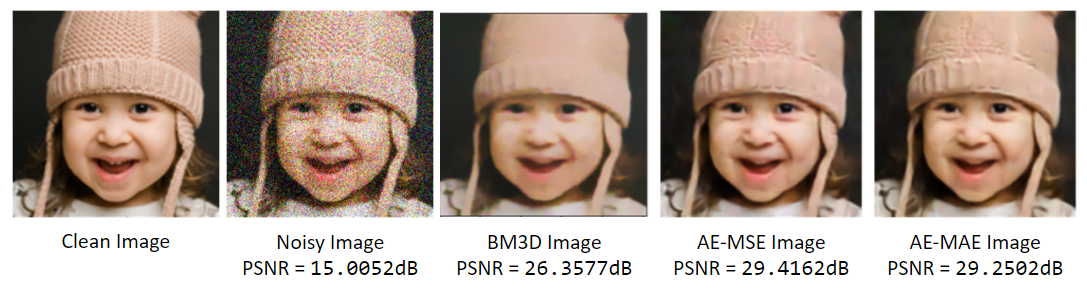